In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
test_images_path = "../data/processed_data/images"  
test_masks_path = "../data/processed_data/masks"   
output_prediction_path = "../predictions"          
os.makedirs(output_prediction_path, exist_ok=True)

In [3]:
model_path = "../models/unet_resnet50_best.keras"  
model = load_model(model_path)

2024-12-16 18:23:42.006845: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-16 18:23:42.006874: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-16 18:23:42.006878: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-16 18:23:42.006896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 18:23:42.006908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
resnet50_encoder = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

In [5]:
def load_random_test_sample(images_path, masks_path):
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.npy')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith('.npy')])
    
    idx = np.random.randint(0, len(image_files))
    img_path = os.path.join(images_path, image_files[idx])
    mask_path = os.path.join(masks_path, mask_files[idx])
    
    img = np.load(img_path)
    mask = np.load(mask_path)
    
    return img, mask, image_files[idx]

In [6]:
def visualize_and_save_predictions(model, images_path, masks_path, output_path):
    img, mask, img_name = load_random_test_sample(images_path, masks_path)

    features = extract_features_from_image(img) 
    
    prediction = model.predict(features)[0] 

    prediction_binary = (prediction > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Orijinal Görsel")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Gerçek Maske")
    if len(mask.shape) == 3:  
        plt.imshow(mask[:, :, 0], cmap="gray")
    else:  
        plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Model Tahmini")
    plt.imshow(prediction_binary[:, :, 0], cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    save_path = os.path.join(output_path, img_name.replace('.npy', '_prediction.npy'))
    np.save(save_path, prediction_binary)
    print(f"Tahmin kaydedildi: {save_path}")


In [7]:
def extract_features_from_image(img):
    img_resized = np.expand_dims(img, axis=0) 
    img_preprocessed = preprocess_input(img_resized * 255.0) 
    features = resnet50_encoder.predict(img_preprocessed)
    return features

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


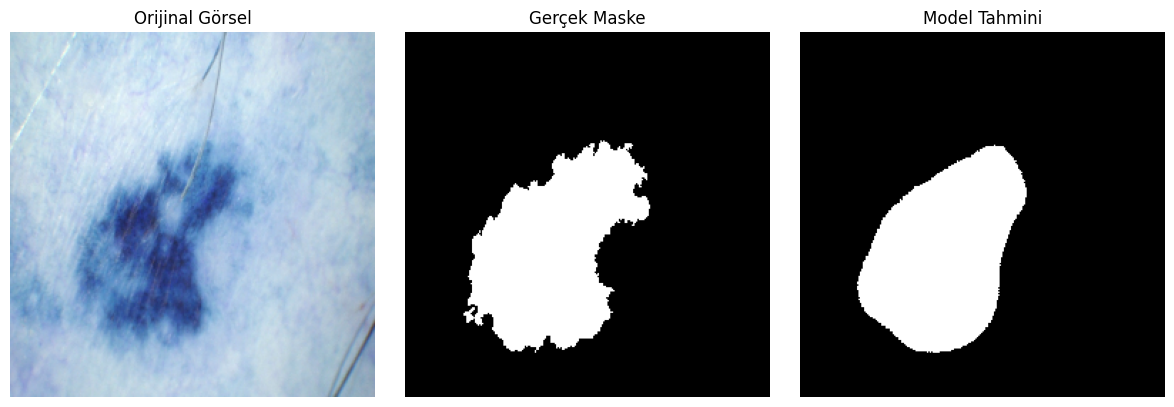

Tahmin kaydedildi: ../predictions/ISIC_0011294_prediction.npy


In [20]:
visualize_and_save_predictions(model, test_images_path, test_masks_path, output_prediction_path)